In [80]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
df = pd.read_csv("CreditScoring.csv")
df.columns = df.columns.str.lower()

In [82]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [83]:
df.income = df.income.replace(to_replace=99999999, value=np.nan)
df.assets = df.assets.replace(to_replace=99999999, value=np.nan)
df.debt = df.debt.replace(to_replace=99999999, value=np.nan)

In [84]:
df = df[df.status != 'unk']

In [85]:
df.reset_index(drop=True)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,default,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4450,ok,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4451,default,0,owner,24,37,married,no,partime,60,90.0,3500.0,0.0,500,963
4452,ok,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


In [86]:
income_avg = df.income.mean()

df['income'] = df['income'].fillna(income_avg)

assets_avg = df.assets.mean()

df['assets'] = df['assets'].fillna(assets_avg)

debts_avg = df.debt.mean()

df['debt'] = df['debt'].fillna(debts_avg)

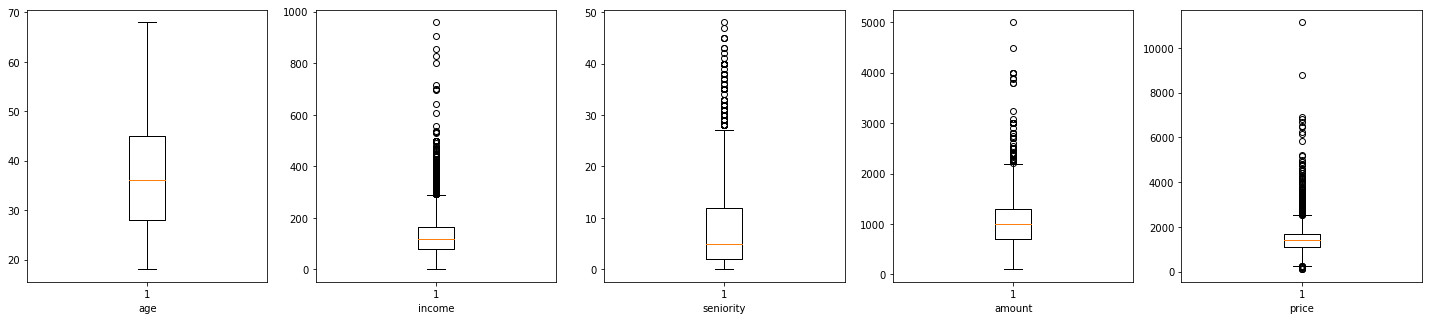

In [87]:
list_ = ["age","income","seniority","amount","price"]

fig, axs = plt.subplots(1, 5, figsize=(25,5))

for enumerate_a, a in enumerate(list_):
    axs[enumerate_a].boxplot(df[a])
    axs[enumerate_a].set_xlabel(a)

In [98]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

df_train_full = df_train_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

del df_train['status']
del df_val['status']
del df_test['status']

In [122]:
df_test.to_csv('customer_test.csv')

In [89]:
df_train_full = df_train_full.reset_index(drop=True)

y_train_full = (df_train_full.status == 'default').astype(int).values
del df_train_full['status']

In [90]:
from sklearn.feature_extraction import DictVectorizer

dicts_train_full = df_train_full.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_full = dv.fit_transform(dicts_train_full)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [91]:
import sys
!{sys.executable} -m pip install xgboost

import xgboost as xgb

dfulltrain = xgb.DMatrix(X_train_full, label=y_train_full,
                    feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

You should consider upgrading via the 'C:\Users\Rajit_Sanghvi\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [92]:
from sklearn.metrics import roc_auc_score

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 4,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=200)

y_pred = model.predict(dtest)
auc = roc_auc_score(y_test, y_pred)
print('val auc: ', auc)

val auc:  0.82641366502126


In [93]:
dv, model

(DictVectorizer(sparse=False), <xgboost.core.Booster at 0x1a4bba55780>)

# Save the model

In [94]:
import pickle

output_file = 'model_xgb.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

# Loading the model

In [95]:
import pickle

input_file =  'model_xgb.bin'

with open(input_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)
    
dv, model

(DictVectorizer(sparse=False), <xgboost.core.Booster at 0x1a4bba550f0>)

In [32]:
customer = {
            "seniority":3,
            "home":"owner",
            "time":36,
            "age":26,
            "marital":"single",
            "records":"no",
            "job":"freelance",
            "expenses":35,
            "income":0.0,
            "assets":60000.0,
            "debt":3000.0,
            "amount":800,
            "price":1000
}

In [63]:
def predict_single(customer, dv, model):
    Xcustomer = dv.transform([customer])
    dcustomer = xgb.DMatrix(Xcustomer, feature_names=dv.get_feature_names())
    y_pred = model.predict(dcustomer)
    return y_pred[0]

In [65]:
predict_single(customer, dv, model)

0.28291568

# Random customer from Test data

In [120]:
import json
customer = df_test.iloc[5].to_json()
customer = json.loads(customer)
customer

{'age': 30,
 'amount': 600,
 'assets': 4000.0,
 'debt': 2800.0,
 'expenses': 60,
 'home': 'owner',
 'income': 70.0,
 'job': 'fixed',
 'marital': 'married',
 'price': 1125,
 'records': 'no',
 'seniority': 14,
 'time': 60}

In [121]:
predict_single(customer, dv, model)

0.26765162